In [1]:
!pip install torch
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torchvision import datasets, transforms
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Input data for January

In [2]:
trip = pd.read_parquet('nyc tlc/fhvhv_tripdata_2021-01.parquet')

##### Combine with weather data


In [3]:
gc.collect()
weather = pd.read_csv('nyc tlc/nyc 2021-01-01 to 2021-12-31.csv')
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[pd.DatetimeIndex(weather['datetime']).month == 1]

# merge weather with trip data
trip_weather = trip.merge(
    weather,
    left_on=trip['pickup_datetime'].dt.floor('d'),
    right_on=weather['datetime'])

trip_weather

,key_0,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,...,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex,severerisk
0,2021-01-01,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
1,2021-01-01,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
2,2021-01-01,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
3,2021-01-01,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
4,2021-01-01,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,...,0.0,0.0,NaN,15.5,69.8,1028.9,50.6,14.0,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11908463,2021-01-31,HV0003,B02765,B02765,2021-01-31 23:13:51,2021-01-31 23:25:03,2021-01-31 23:25:40,2021-01-31 23:40:10,89,71,...,10.0,4.3,38.9,27.5,73.5,1025.3,65.3,12.7,2,NaN
11908464,2021-01-31,HV0003,B02872,B02872,2021-01-31 23:23:56,2021-01-31 23:29:03,2021-01-31 23:29:31,2021-01-31 23:47:44,182,167,...,10.0,4.3,38.9,27.5,73.5,1025.3,65.3,12.7,2,NaN
11908465,2021-01-31,HV0003,B02872,B02872,2021-01-31 23:42:53,2021-01-31 23:49:23,2021-01-31 23:49:32,2021-02-01 00:04:36,167,169,...,10.0,4.3,38.9,27.5,73.5,1025.3,65.3,12.7,2,NaN
11908466,2021-01-31,HV0003,B02764,B02764,2021-01-31 23:04:32,2021-01-31 23:09:13,2021-01-31 23:09:29,2021-01-31 23:27:46,188,37,...,10.0,4.3,38.9,27.5,73.5,1025.3,65.3,12.7,2,NaN


##### Calculate hourly foot traffic

In [4]:
trip_weather['PU_day'] = pd.DatetimeIndex(
    trip_weather['pickup_datetime']).day
trip_weather['PU_hour'] = pd.DatetimeIndex(
    trip_weather['pickup_datetime']).hour
#trip_weather['PU_time'] = trip_weather['pickup_datetime'].apply(lambda x: x.value / 10**9).astype('int64')

gp = trip_weather.groupby(['PU_day', 'PU_hour', 'PULocationID'])['pickup_datetime'].count()

PU_times = gp.reset_index().rename(columns={'pickup_datetime': 'PU_times'})
PU_times

,PU_day,PU_hour,PULocationID,PU_times
0,1,0,3,80
1,1,0,4,138
2,1,0,5,11
3,1,0,6,21
4,1,0,7,249
...,...,...,...,...
185483,31,23,260,58
185484,31,23,261,24
185485,31,23,262,42
185486,31,23,263,53


##### Merge hourly foot traffic with travel weather data

In [5]:
gc.collect()

trip_weather_data = trip_weather[['pickup_datetime', 'PULocationID', 'DOLocationID',
              'base_passenger_fare', 'tolls', 'congestion_surcharge',
              'temp', 'feelslike', 'dew', 'humidity', 'precip',
              'snow', 'snowdepth', 'windspeed', 'sealevelpressure',
              'cloudcover', 'visibility', 'uvindex', 'PU_day', 'PU_hour']]

trip_weather_data = trip_weather_data.merge(PU_times, on=['PU_day', 'PU_hour', 'PULocationID'])
trip_weather_data

,pickup_datetime,PULocationID,DOLocationID,base_passenger_fare,tolls,congestion_surcharge,temp,feelslike,dew,humidity,...,snow,snowdepth,windspeed,sealevelpressure,cloudcover,visibility,uvindex,PU_day,PU_hour,PU_times
0,2021-01-01 00:33:44,230,166,22.28,0.0,2.75,2.5,-0.2,-3.0,67.8,...,0.0,0.0,15.5,1028.9,50.6,14.0,3,1,0,145
1,2021-01-01 00:47:11,230,265,20.62,20.0,0.00,2.5,-0.2,-3.0,67.8,...,0.0,0.0,15.5,1028.9,50.6,14.0,3,1,0,145
2,2021-01-01 00:36:20,230,186,10.44,0.0,2.75,2.5,-0.2,-3.0,67.8,...,0.0,0.0,15.5,1028.9,50.6,14.0,3,1,0,145
3,2021-01-01 00:19:54,230,87,22.12,0.0,2.75,2.5,-0.2,-3.0,67.8,...,0.0,0.0,15.5,1028.9,50.6,14.0,3,1,0,145
4,2021-01-01 00:46:03,230,71,44.96,0.0,2.75,2.5,-0.2,-3.0,67.8,...,0.0,0.0,15.5,1028.9,50.6,14.0,3,1,0,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11908463,2021-01-31 23:08:32,204,5,6.33,0.0,0.00,-4.9,-9.4,-11.5,60.7,...,10.0,4.3,27.5,1025.3,65.3,12.7,2,31,23,2
11908464,2021-01-31 23:27:23,204,109,17.72,0.0,0.00,-4.9,-9.4,-11.5,60.7,...,10.0,4.3,27.5,1025.3,65.3,12.7,2,31,23,2
11908465,2021-01-31 23:30:47,30,258,20.08,0.0,0.00,-4.9,-9.4,-11.5,60.7,...,10.0,4.3,27.5,1025.3,65.3,12.7,2,31,23,1
11908466,2021-01-31 23:32:28,207,95,18.06,0.0,0.00,-4.9,-9.4,-11.5,60.7,...,10.0,4.3,27.5,1025.3,65.3,12.7,2,31,23,2


##### Use the LASSO model to select relevant features

In [6]:
gc.collect()
X = trip_weather_data[['DOLocationID', 'base_passenger_fare', 'tolls', 
                    'congestion_surcharge', 'temp', 'feelslike',
                    'dew', 'humidity', 'precip', 'snow', 'snowdepth',
                    'windspeed', 'sealevelpressure', 'cloudcover', 'visibility',
                    'uvindex']]

Y = trip_weather_data['PU_times']

idx = np.random.randint(0, len(X), 7000000)

lasso = Lasso(alpha=0.1,
            positive=True,
            fit_intercept=False,
            max_iter=1000,
            tol=0.0001)
            
model = make_pipeline(StandardScaler(), lasso)
model.fit(X.iloc[idx], Y.iloc[idx])
print(lasso.coef_)

selected_data = trip_weather_data[['PULocationID', 'base_passenger_fare', 
                                   'congestion_surcharge', 'precip', 'windspeed', 
                                   'sealevelpressure', 'uvindex', 'PU_day', 
                                   'PU_hour', 'PU_times', 'pickup_datetime']]
selected_data

[0.         0.17183752 0.         4.3275742  0.         0.
 0.         0.         4.96779166 0.         0.         7.48871597
 2.67541909 0.         0.         1.90958476]


,PULocationID,base_passenger_fare,congestion_surcharge,precip,windspeed,sealevelpressure,uvindex,PU_day,PU_hour,PU_times,pickup_datetime
0,230,22.28,2.75,15.33,15.5,1028.9,3,1,0,145,2021-01-01 00:33:44
1,230,20.62,0.00,15.33,15.5,1028.9,3,1,0,145,2021-01-01 00:47:11
2,230,10.44,2.75,15.33,15.5,1028.9,3,1,0,145,2021-01-01 00:36:20
3,230,22.12,2.75,15.33,15.5,1028.9,3,1,0,145,2021-01-01 00:19:54
4,230,44.96,2.75,15.33,15.5,1028.9,3,1,0,145,2021-01-01 00:46:03
...,...,...,...,...,...,...,...,...,...,...,...
11908463,204,6.33,0.00,1.96,27.5,1025.3,2,31,23,2,2021-01-31 23:08:32
11908464,204,17.72,0.00,1.96,27.5,1025.3,2,31,23,2,2021-01-31 23:27:23
11908465,30,20.08,0.00,1.96,27.5,1025.3,2,31,23,1,2021-01-31 23:30:47
11908466,207,18.06,0.00,1.96,27.5,1025.3,2,31,23,2,2021-01-31 23:32:28


##### Plot the foot traffic time series for location 230

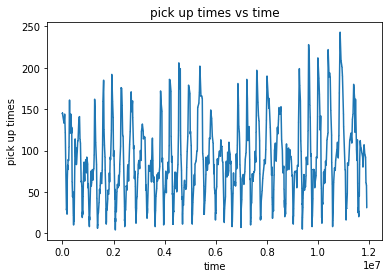

In [7]:
some_loc = selected_data.loc[selected_data['PULocationID'] == 230]
some_loc = some_loc.sort_values(by='pickup_datetime')

plt.title('pick up times vs time')
plt.xlabel('time')
plt.ylabel('pick up times')
plt.plot(some_loc['PU_times'])

##### Define the dataset

In [8]:
from torch.utils.data import Dataset

class trip_weather_Dataset(Dataset):
    def __init__(self, X, Y, seq_len):

        super(trip_weather_Dataset, self).__init__()

        self.X = []
        self.Y = []

        if len(X) > seq_len:
            for i in range(len(X)-seq_len):
                _x = X[i:(i+seq_len)]
                _y = Y[i+seq_len]
                
                self.X.append(_x)
                self.Y.append(_y)
        else:
            self.X.append(X[:len(X)])
            self.Y.append(Y[len(X)-1])

        self.X = torch.tensor(np.array(self.X), dtype=torch.float)
        self.Y = torch.tensor(np.array(self.Y), dtype=torch.float)

        #print(self.X.shape)
    
    def __len__(self):
        '''return len of dataset'''
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


##### Define the model: RNN→LSTM→GRU

In [9]:
class Model(nn.Module):
    def __init__(self, nonlinearity, in_dim, rnn_hidden_dim, lstm_hidden_dim, gru_hidden_dim):

        super(Model, self).__init__()

        self.rnn = nn.RNN(input_size=in_dim, hidden_size=rnn_hidden_dim, 
                          nonlinearity=nonlinearity, batch_first=True)

        self.lstm = nn.LSTM(input_size=rnn_hidden_dim, hidden_size=lstm_hidden_dim,
                            batch_first=True)

        self.gru = nn.GRU(input_size=lstm_hidden_dim, hidden_size=gru_hidden_dim,
                          batch_first=True)

        self.fc1 = nn.Linear(gru_hidden_dim, 32)

        self.dp = nn.Dropout(p=0.2)

        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):

        output, rnn_h = self.rnn(x)
        #print(output)

        output, (lstm_h, cn) = self.lstm(output)
        #print(output)

        output, gru_h = self.gru(output)
        #print(output)

        x = F.relu(self.fc1(gru_h[0])) # B * 256

        x = self.dp(x)

        x = self.fc2(x) # B * 1

        return x

Select CPU or GPU

In [10]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


##### Set up training

In [11]:
def train(epochs, train_loader, optimizer, model):

    rnn_h = None
    for epoch in range(1, epochs + 1):
        sum_loss = 0.
        for batch_idx, (X, y) in enumerate(train_loader):
            
            X, y = X.to(device), y.to(device)

            # zero out prev gradients
            optimizer.zero_grad()

            output = model(X)

            # print(output.shape)
            # print(y.shape)

            loss = F.mse_loss(output, y)

            sum_loss += loss.item()

            loss.backward()
            optimizer.step()
            
        sum_loss /= len(train_loader)

        checkpoint = {
            'epoch': epoch,
            'loss': sum_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, 'checkpoint.pth')

        # if epoch % 10 == 0:
        #     print(f'Epoch: {epoch}, Loss: {sum_loss:.6f}')

    return


In [12]:
uniq_loc = sorted(selected_data['PULocationID'].unique())
learning_rate = 0.01
epochs = 100
nonlinearity = 'relu'
in_dim = 9
rnn_hidden_dim = 8
lstm_hidden_dim = 16
gru_hidden_dim = 8
seq_len = 5

model = Model(nonlinearity, in_dim, rnn_hidden_dim, 
              lstm_hidden_dim, gru_hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

test_loc = dict()

model = model.to(device)
model.train()

for idx, (item) in enumerate(tqdm(uniq_loc)):
    some_loc = selected_data.loc[selected_data['PULocationID'] == item]
    train_size = int(len(some_loc) * 0.6)

    if train_size == 0: continue

    scaler = StandardScaler()
    scaler.fit(some_loc.iloc[:train_size, :10])
    SS_some_loc = scaler.transform(some_loc.iloc[:train_size, :10])
    X_train = SS_some_loc[:, 1:10]
    Y_train = SS_some_loc[:, 9:10]

    SS_some_loc = scaler.transform(some_loc.iloc[train_size:, :10])
    X_test = SS_some_loc[:, 1:10]
    Y_test = SS_some_loc[:, 9:10]

    test_loc[item] = (X_test, Y_test)

    train_loader = du.DataLoader(
                        dataset=trip_weather_Dataset(X_train, Y_train, seq_len),
                        batch_size=200, shuffle=False)
    
    train(epochs, train_loader, optimizer, model)

    if idx == 20:
        break

  8%|▊         | 20/262 [15:13<3:04:11, 45.67s/it]


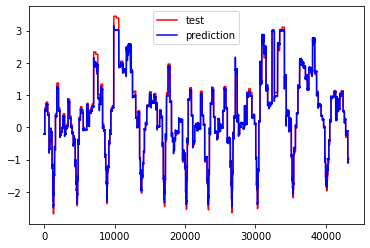

In [14]:
model.eval()
preds = []
X_test, Y_test = test_loc[7]
test_loader = du.DataLoader(
                    dataset=trip_weather_Dataset(X_test, Y_test, seq_len),
                    batch_size=100, shuffle=False)
for batch_idx, (X, y) in enumerate(test_loader):

    X = X.to(device)

    pred = model(X)
    preds.extend(pred.cpu().detach().numpy().tolist())

plt.plot(Y_test[:, 0], c='r', label='test')
plt.plot(preds, c='b', label='prediction')
plt.legend()
plt.show()